In [2]:
#load packages
import os
from os import listdir
from os.path import isfile, join
import re
import jieba
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, CategoricalNB, MultinomialNB, BernoulliNB
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import string
import numpy as np
import itertools
import json
import csv
import gc
from sklearn.metrics import ConfusionMatrixDisplay
gc.collect()


0

In [3]:
root = './subtitle_corpora/'
corpora_path = root+'Corpora/Chinese/'
json_path = root+'json_files/'
filename = "chinese_cor.json"
ref_path = root+'thesis_files/chinese/'
source_file = "chinese_cor.json"

no_turns = 5 #window size +- number of turns in dialogue context to extract features from. Includes current

labels =['你','您']

In [11]:
class data:
    
    def __init__(self,no_turns,root,corpora_path,json_path,filename,ref_path,labels):
        self.no_turns = no_turns #number of lines before pronoun appears
        self.root = root #directory with corpus files
        self.corpora_path = corpora_path
        self.json_path = json_path
        self.filename = filename
        self.ref_path = ref_path
        self.labels = labels #the classes of the classifier (pronouns)
        self.raw_corpus =""#cleaned version of entire corpus that remains a single string
        self.instance_dict = Counter()
        self.instance_array = []
        self.context_array = []
        self.gt_array = []
        
    def create_from_files(self):
        """
        Create the corpus using srt or txt files from the given directory.
        The exact functions used here will be language-specific.
        """
        
        #create tokenized list
        only_files = []
        for dirpath, subdirs, files in os.walk(self.corpora_path):
            for x in files:
                if (x.endswith('srt'))|(x.endswith('txt')):
                    only_files.append(os.path.join(dirpath, x))


        raw_corpus = " ".join(open(f,encoding='utf8').read() for f in only_files)
        raw_corpus = re.sub('\n+','\n',raw_corpus)

        list_raw = raw_corpus.split('\n')
        
        #Create dictionary objects
        element_counter = 0
        for i in range(0,len(list_raw)):
            for pronoun in self.labels:
                if pronoun in list(jieba.cut(list_raw[i])):
                    
                    self.instance_array.append(element_counter)
                    filtered_list = []
                    single_context = ""
                    for r in range(max(i-no_turns,0),i):
                        filtered_list.append(list_raw[r])
                        single_context += list_raw[r]+"\n"
                    
                    self.instance_dict[element_counter] = {}
                    self.instance_dict[element_counter]["dialog"] = filtered_list
                    self.instance_dict[element_counter]["gt"] = pronoun
                    self.instance_dict[element_counter]["cur_utt"] = list_raw[i]
                    self.instance_dict[element_counter]["single_context"] = single_context
                    self.instance_dict[element_counter]["predicted"]= ""
                    self.context_array.append(single_context)
                    self.gt_array.append(pronoun)
                    element_counter+=1
              
    def read_from_json(self):
        
        #read from existing .json formats
        with open(self.json_path+self.filename, "r") as path_in:
            self.instance_dict = json.loads(path_in.read())

        self.instance_dict = {int(k): self.instance_dict[k] for k in self.instance_dict}
        self.instance_dict
    
    def save_to_json(self):
        #write to .json formats
        df = self.instance_dict
        with open(self.json_path+self.filename, "w") as outfile:
            json.dump(df,outfile)
            
    def get_accuracy(self):
        #Get accuracy
        correct = 0
        total = 0
        for i in self.instance_array:
            total +=1
            if self.instance_dict[i]["gt"]==self.instance_dict[i]["predicted"]:
                correct += 1
        return correct/total
    
def ch_tokenizer(input_str:str):
    #tokenize sentence and return as list
    tokenized = list(jieba.cut(input_str))
    return tokenized

In [5]:
#test creating data class
data_zh = data(no_turns,root,corpora_path,json_path,filename,ref_path,labels)

In [6]:
data_zh.create_from_files()
#test
data_zh.instance_dict[0]

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.463 seconds.
Prefix dict has been built successfully.


{'dialog': [],
 'gt': '你',
 'cur_utt': '我看你',
 'single_context': '',
 'predicted': ''}

In [18]:
#Divide data into train and test
X = [data_zh.instance_dict[item]['single_context'] for item in data_zh.instance_dict]
#y = [('__label__'+data_zh.instance_dict[item]['gt']) for item in data_zh.instance_dict]
y = [data_zh.instance_dict[item]['gt'] for item in data_zh.instance_dict]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [10]:
X_train[0]

'我对不起你\n好像好多事就结束了\n很多人说不出口\n她就是要一个理\n她就是\n'

Attempt classification using simple bag of words approach, and fitting various classifiers

In [19]:
cv = CountVectorizer(tokenizer=ch_tokenizer,ngram_range=(1,3),min_df=2,max_df=0.55)

count_vector=cv.fit_transform(X_train)

X_train = count_vector.toarray()

X_test = cv.transform(X_test).toarray()

/home2/elyeb/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [16]:
from sklearn.naive_bayes import GaussianNB

NB = GaussianNB()

In [20]:
NB.fit(X_train, y_train)
y_pred = NB.predict(X_test)

Counter(y_pred)

Counter({'你': 1202, '您': 22})

In [21]:
Counter(y_test)

Counter({'你': 1111, '您': 113})

0.911


/home2/elyeb/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 20320 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home2/elyeb/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 24744 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home2/elyeb/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 20320 missing from current font.
  font.set_text(s, 0, flags=flags)
/home2/elyeb/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 24744 missing from current font.
  font.set_text(s, 0, flags=flags)


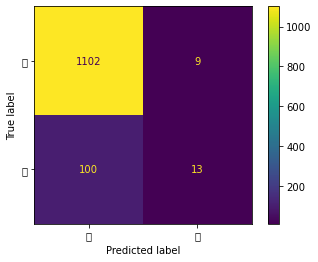

In [23]:
#accuracy on test set = 0.711
print(round((y_pred==y_test).sum()/len(y_pred), 3))


plt.rcParams['font.sans-serif'] = ['SimHei']
ConfusionMatrixDisplay.from_predictions(y_test,y_pred)

Use fastText embeddings as word vectors

In [13]:
#fasttext models
import fasttext
import fasttext.util

ft = fasttext.load_model(root+'thesis/fastText/'+'cc.zh.300.bin')

ft.get_word_vector('平时').shape

(300,)

In [15]:
words = set(ft.get_words())

#here is where I would add embeddings to the X_train
X_train_vect = np.array([np.array([ft.get_word_vector(i) for i in ls if i in words])  
for ls in X_train]) 

X_test_vect = np.array([np.array([ft.get_word_vector(i) for i in ls if i in words])  
for ls in X_test]) 
len(X_test_vect)

# Compute sentence vectors by averaging the word vectors for the words contained in the sentence
X_train_vect_avg = []
for v in X_train_vect:
    if v.size:
        X_train_vect_avg.append(v.mean(axis=0)) #sum tested but results in lower accuracy
    else:
        X_train_vect_avg.append(np.zeros(300, dtype=float))
        
X_test_vect_avg = []
for v in X_test_vect:
    if v.size:
        X_test_vect_avg.append(v.mean(axis=0)) #sum tested but results in lower accuracy
    else:
        X_test_vect_avg.append(np.zeros(300, dtype=float))

/tmp/ipykernel_80138/3810717025.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_train_vect = np.array([np.array([ft.get_word_vector(i) for i in ls if i in words])
/tmp/ipykernel_80138/3810717025.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_test_vect = np.array([np.array([ft.get_word_vector(i) for i in ls if i in words])


In [19]:
# Instantiate and fit a basic Random Forest model on top of the vectors

from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf_model = rf.fit(X_train_vect_avg, y_train)


# Use the trained model to make predictions on the test data
y_pred = rf_model.predict(X_test_vect_avg)

print(Counter(y_pred))

print(Counter(y_test))

#accuracy on test set = 0.711
round((y_pred==y_test).sum()/len(y_pred), 3)

Counter({'你': 1222, '您': 2})
Counter({'你': 1134, '您': 90})


0.926

In [17]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test,y_pred)

col_0,你
col_1,你
col_2,你
col_3,你
col_4,你
col_5,你
col_6,你
col_7,您
col_8,你
col_9,你
col_10,你


In [24]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[1133,    1],
       [  89,    1]])

In [25]:
#accuracy on training set = 1.0
y_train_pred = rf_model.predict(X_train_vect_avg)
round((y_train_pred==y_train).sum()/len(y_train_pred), 3)

1.0

Conclusions:
- First time that a model starts predicting 您, so that's success
- 1 of them is correct

Experiment using fastText to learn word embeddings from current corpus

In [13]:
import fasttext
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay
# Skipgram model :
ft = fasttext.train_unsupervised(root+'thesis/fastText/zh/'+'data.txt', model='skipgram')

# or, cbow model :
#model = fasttext.train_unsupervised('data.txt', model='cbow')

Read 0M words
Number of words:  305
Number of labels: 0
Progress: 100.0% words/sec/thread:  834317 lr:  0.000000 avg.loss:  4.102594 ETA:   0h 0m 0s


In [14]:
#Follow same vector averaging approach as used with word2vec,
#default vector size is 100 instead of 300
words = set(ft.get_words())

#here is where I would add embeddings to the X_train
X_train_vect = np.array([np.array([ft.get_word_vector(i) for i in ls if i in words])  
for ls in X_train]) 

X_test_vect = np.array([np.array([ft.get_word_vector(i) for i in ls if i in words])  
for ls in X_test]) 
len(X_test_vect)

# Compute sentence vectors by averaging the word vectors for the words contained in the sentence
X_train_vect_avg = []
for v in X_train_vect:
    if v.size:
        X_train_vect_avg.append(v.mean(axis=0)) #sum tested but results in lower accuracy
    else:
        X_train_vect_avg.append(np.zeros(100, dtype=float))
        
X_test_vect_avg = []
for v in X_test_vect:
    if v.size:
        X_test_vect_avg.append(v.mean(axis=0)) #sum tested but results in lower accuracy
    else:
        X_test_vect_avg.append(np.zeros(100, dtype=float))

# Instantiate and fit a basic Random Forest model on top of the vectors


rf = RandomForestClassifier()
rf_model = rf.fit(X_train_vect_avg, y_train)


# Use the trained model to make predictions on the test data
y_pred = rf_model.predict(X_test_vect_avg)

print(Counter(y_pred))

print(Counter(y_test))


/tmp/ipykernel_1388569/2192724084.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_train_vect = np.array([np.array([ft.get_word_vector(i) for i in ls if i in words])
/tmp/ipykernel_1388569/2192724084.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_test_vect = np.array([np.array([ft.get_word_vector(i) for i in ls if i in words])


Counter({'你': 1214, '您': 10})
Counter({'你': 1134, '您': 90})


In [25]:
from sklearn.metrics  import f1_score,accuracy_score, confusion_matrix


In [26]:
confusion_matrix(y_test,y_pred)

array([[1102,    9],
       [ 100,   13]])

0.911


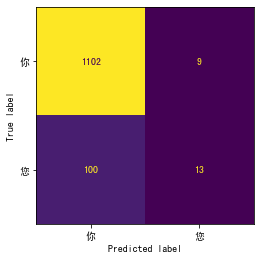

In [29]:
#accuracy on test set = 0.711
print(round((y_pred==y_test).sum()/len(y_pred), 3))
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
disp = ConfusionMatrixDisplay.from_predictions(y_test,y_pred,colorbar=False)
plt.show()